# Binary CSP solver

*Guillaume DALLE*

In [1]:
using ProgressMeter
using PyPlot
using DataFrames
using CSV
import LightGraphs

## 1. CSP structure and backtracking

### 1.1) CSP object

In [2]:
mutable struct CSP
    n_variables::Int64
    names::Array{String, 1}
    domain::Array{Array{Int64, 1}, 1}
    domain_max::Array{Int64, 1}
    value_scores::Array{Array{Int64, 1}, 1}
    value_order::Array{Array{Int64, 1}, 1}
        
    n_constraints::Int64
    constraint_var1::Array{Int64, 1}
    constraint_var2::Array{Int64, 1}
    matrix_storage::Bool
    constraint_satisfaction_mat::Array{Array{Bool, 2}, 1}
    constraint_satisfaction_fun::Array{Function, 1}
    
    var1_constraints::Array{Array{Int64, 1}, 1}
    var2_constraints::Array{Array{Int64, 1}, 1}
    
    params::Dict{String, Any}
    
    CSP() = new(
        0,
        String[],
        Array{Int64, 1}[],
        Int64[],
        Array{Int64, 1}[],
        Array{Int64, 1}[],
        
        0,
        Int64[],
        Int64[],
        false,
        Array{Bool, 2}[],
        Function[],
        
        Array{Int64, 1}[],
        Array{Int64, 1}[],
        
        Dict{String, Any}(
            "matrix_storage"=>false,
            "variable_selection"=>"domain_size",
            "dynamic_value_selection"=>"none",
            "static_value_selection"=>"none",
            "look_ahead"=>"FC",
            "time_limit"=>1.,
        ),
    )
end

### 1.2) Variables and constraints

In [3]:
function add_variable!(csp::CSP, name::String, domain_size::Int64)
    csp.n_variables += 1
    push!(csp.names, name)
    push!(csp.domain, collect(1:domain_size))
    push!(csp.domain_max, domain_size)
    
    push!(csp.value_scores, zeros(Float64, domain_size))
    push!(csp.value_order, collect(1:domain_size))
    
    push!(csp.var1_constraints, Int64[])
    push!(csp.var2_constraints, Int64[])
end

add_variable! (generic function with 1 method)

In [4]:
function add_individual_constraint!(csp::CSP, x::Int64, subdomain::Array{Int64, 1})
    i = 1
    while i <= csp.domain_max[x]
        a = csp.domain[x][i]
        if !(a in subdomain)
            csp.domain[x][i] = csp.domain[x][csp.domain_max[x]]
            csp.domain[x][csp.domain_max[x]] = a
            csp.domain_max[x] -= 1
        else
            i += 1
        end
    end
end

add_individual_constraint! (generic function with 1 method)

In [5]:
function add_constraint!(csp::CSP, x::Int64, y::Int64, compatibility::Function)
    csp.n_constraints += 1
    
    push!(csp.constraint_var1, x)
    push!(csp.constraint_var2, y)
    push!(csp.var1_constraints[x], csp.n_constraints)
    push!(csp.var2_constraints[y], csp.n_constraints)

    push!(csp.constraint_satisfaction_fun, compatibility)
end

add_constraint! (generic function with 1 method)

In [6]:
function set_params(csp::CSP, params::Dict{String, Any})
    for (key, val) in params
        csp.params[key] = val
    end
end

function set_params(csp::CSP, params::Dict{String, String})
    for (key, val) in params
        csp.params[key] = val
    end
end

function set_params(csp::CSP, params::Dict{String, Float64})
    for (key, val) in params
        csp.params[key] = val
    end
end

set_params (generic function with 3 methods)

In [7]:
function backup_domains(csp::CSP)
    domain::Array{Array{Int64, 1}, 1} = Array{Int64, 1}[]
    domain_max::Array{Int64, 1} = Int64[]
    for x in 1:csp.n_variables
        push!(domain, copy(csp.domain[x]))
        push!(domain_max, csp.domain_max[x])
    end
    return domain, domain_max
end

function restore_domains!(csp::CSP, domain::Array{Array{Int64, 1}, 1}, domain_max::Array{Int64, 1})
    for x in 1:csp.n_variables
        csp.domain[x] = copy(domain[x])
        csp.domain_max[x] = domain_max[x]
    end
end

restore_domains! (generic function with 1 method)

### 1.3) Consistency check

In [8]:
function check_feasibility(csp::CSP, instantiation::Array{Int64, 1}, x::Int64)
    if x == -1
        return true
    end
    for cons in csp.var1_constraints[x]
        y::Int64 = csp.constraint_var2[cons]
        a = instantiation[x]
        b = instantiation[y]
        if (a !== -1) && (b !== -1)
            if csp.matrix_storage
                satisfied = csp.constraint_satisfaction_mat[cons][a, b]
            else
                satisfied = csp.constraint_satisfaction_fun[cons](csp, x, y, a, b)
            end
            if !satisfied
                return false
            end
        end
    end
    return true
end

check_feasibility (generic function with 1 method)

### 1.4) Choice of variable / value

In [9]:
function evaluate_variable(csp::CSP, x::Int64)
    if csp.params["variable_selection"] == "order"
        eval = x
    elseif csp.params["variable_selection"] == "random"
        eval = rand()
    elseif csp.params["variable_selection"] == "domain_size"
        eval = - csp.domain_max[x]
    elseif csp.params["variable_selection"] == "domain_size_better"
        eval = - csp.domain_max[x] - (abs(x - csp.n_variables / 2)/csp.n_variables)
    elseif csp.params["variable_selection"] == "domain_size_random"
        eval = - csp.domain_max[x] + rand()
    elseif csp.params["variable_selection"] == "constraints"
        eval = length(csp.var1_constraints[x])
    elseif csp.params["variable_selection"] == "constraints_random"
        eval = length(csp.var1_constraints[x]) + rand()
    else
        eval = 1
    end
    return eval
end

function choose_next_variable(csp::CSP, instantiation::Array{Int64, 1})
    best_x::Int64 = -1
    best_eval::Float64 = -Inf
        
    for x in 1:csp.n_variables
        
        if instantiation[x] != -1
            continue
        else
            eval = evaluate_variable(csp, x)
            if eval > best_eval
                best_x = x
                best_eval = eval
            end
        end
    end
    return best_x
end

choose_next_variable (generic function with 1 method)

### 1.5) Look-ahead

In [10]:
function do_look_ahead!(csp::CSP, instantiation::Array{Int64, 1}, x::Int64)
    previous_domain_max::Array{Int64, 1} = copy(csp.domain_max)
    
    a::Int64 = instantiation[x]
    for i in 1:csp.domain_max[x]
        if (csp.domain[x][i] == a)
            csp.domain[x][i] = csp.domain[x][1]
            csp.domain[x][1] = a
            csp.domain_max[x] = 1
            break
        end
    end
    
    if csp.params["look_ahead"] == "FC"
        forward_checking!(csp, instantiation, x)
    elseif csp.params["look_ahead"] == "MAC3"
        AC3!(csp, instantiation)
    end
    
    return previous_domain_max
end

function undo_look_ahead!(csp::CSP, previous_domain_max::Array{Int64, 1})
    csp.domain_max = copy(previous_domain_max)
end

undo_look_ahead! (generic function with 1 method)

In [11]:
function forward_checking!(csp::CSP, instantiation::Array{Int64, 1}, x::Int64)
    
    a::Int64 = instantiation[x]
    
    for cons in csp.var1_constraints[x]
        y = csp.constraint_var2[cons]
        
        if instantiation[y] != -1
            continue
        end

        j = 1
        while j <= csp.domain_max[y]
            b = csp.domain[y][j]
            if csp.matrix_storage
                satisfied = csp.constraint_satisfaction_mat[cons][a, b]
            else
                satisfied = csp.constraint_satisfaction_fun[cons](csp, x, y, a, b)
            end
            if !satisfied
                csp.domain[y][j] = csp.domain[y][csp.domain_max[y]]
                csp.domain[y][csp.domain_max[y]] = b
                csp.domain_max[y] -= 1
            else
                j += 1
            end
        end
    end
end

forward_checking! (generic function with 1 method)

In [12]:
function AC3!(csp::CSP, instantiation::Array{Int64, 1})
    
    to_test = Set{Int64}()
    for cons in 1:csp.n_constraints
        push!(to_test, cons)
    end
    
    while !isempty(to_test)
        cons = pop!(to_test)
        x = csp.constraint_var1[cons]
        y = csp.constraint_var2[cons]
        
        i = 1
        while i <= csp.domain_max[x]
            a = csp.domain[x][i]
            a_supported::Bool = false
            for b in csp.domain[y][1:csp.domain_max[y]]
                if csp.matrix_storage
                    satisfied = csp.constraint_satisfaction_mat[cons][a, b]
                else
                    satisfied = csp.constraint_satisfaction_fun[cons](csp, x, y, a, b)
                end
                if satisfied
                    a_supported = true
                    break
                end
            end
            
            if !a_supported
                csp.domain[x][i] = csp.domain[x][csp.domain_max[x]]
                csp.domain[x][csp.domain_max[x]] = a
                csp.domain_max[x] -= 1
                for cons_impacted in csp.var2_constraints[x]
                    if csp.constraint_var1[cons] != y
                        push!(to_test, cons_impacted)
                    end
                end
            else
                i += 1
            end
        end
    end

end

AC3! (generic function with 1 method)

### 1.6) Backtracking

In [13]:
function backtrack!(
        csp::CSP,
        instantiation::Array{Int64, 1},
        last_x::Int64,
        nodes_explored::Int64,
        initial_time::Float64
    )
    time_elapsed = time() - initial_time
    if time_elapsed > csp.params["time_limit"]
        error("Time limit exceeded")
    end

    if !check_feasibility(csp, instantiation, last_x)
        return (false, instantiation, nodes_explored)
    end
    
    x = choose_next_variable(csp, instantiation)
    if x == -1
        return (true, instantiation, nodes_explored)
    end
        
    domain_to_explore = copy(csp.domain[x][1:csp.domain_max[x]])
    
    for a in domain_to_explore
        nodes_explored += 1
        instantiation[x] = a
        look_ahead_result = do_look_ahead!(csp, instantiation, x)
                
        (solution_found, solution, nodes_explored) = backtrack!(
            csp, instantiation, x, nodes_explored, initial_time)
        if solution_found
            return (true, solution, nodes_explored)
        end
        
        instantiation[x] = -1
        undo_look_ahead!(csp, look_ahead_result)

    end
    return false, instantiation, nodes_explored
end

function backtrack!(csp::CSP)
    backtrack!(csp, -ones(Int64, csp.n_variables), -1, 0, time())
end

backtrack! (generic function with 2 methods)

In [14]:
function add_matrix_storage!(csp::CSP)
    csp.matrix_storage = true
    for cons in 1:csp.n_constraints
        x = csp.constraint_var1[cons]
        y = csp.constraint_var2[cons]
        satisfaction = zeros(Bool, length(csp.domain[x]), length(csp.domain[y]))
        for a in csp.domain[x], b in csp.domain[y]
            if csp.constraint_satisfaction_fun[cons](csp, x, y, a, b)
                satisfaction[a, b] = true
                csp.value_scores[x][a] += 1
                csp.value_scores[y][b] += 1
            end
        end
        push!(csp.constraint_satisfaction_mat, satisfaction)
    end
end

function sort_values!(csp::CSP)
    for x in 1:csp.n_variables
        value_sorting_criterion(a::Int64) = csp.value_scores[x][a]
        csp.value_order[x] = sort(csp.value_order[x], by=value_sorting_criterion)
    end
end

function preprocess!(csp::CSP)
    if csp.params["matrix_storage"]
        add_matrix_storage!(csp)
        sort_values!(csp)
    end
end

preprocess! (generic function with 1 method)

In [15]:
function solve!(csp::CSP, global_time_limit::Float64)
    randomness_present = false
    for (key, val) in csp.params
        if typeof(val) == String && occursin("random", val)
            randomness_present = true
            break
        end
    end
    if !randomness_present
        csp.params["time_limit"] = global_time_limit
    else
        csp.params["time_limit"] = global_time_limit / 5
    end
    
    domain, domain_max = backup_domains(csp)
    
    initial_time::Float64 = time()
    while time() - initial_time < global_time_limit
        try
            preprocess!(csp)
            status, instantiation, nodes_explored = backtrack!(csp)
            return (status, instantiation, nodes_explored, time() - initial_time)
        catch
            restore_domains!(csp, domain, domain_max)
        end
    end
    return nothing
end

function solve!(csp::CSP)
    return solve!(csp, 5.)
end

function solve_verbose!(csp::CSP)
    (status, instantiation, nodes_explored) = solve!(csp)
    if !status
        println("\nStatus: unfeasible")
    else
        println("\nStatus: solved")
        println("\nNodes explored: ", nodes_explored)
        println("\nSolution: ")
        for x in 1:csp.n_variables
            println(csp.names[x], ": ", instantiation[x])
        end
    end
    println()
    return (status, instantiation, nodes_explored)
end

solve_verbose! (generic function with 1 method)

## 2. Applications

### 2.1) N-queens problem

In [16]:
function compatibility_nqueens(csp::CSP, var1::Int64, var2::Int64, value1::Int64, value2::Int64)
    # Exclude same row, same diagonal, same antidiagonal
    if (value1 != value2) && abs(value1 - value2) != abs(var1 - var2)
        if (var1, var2) != (1, csp.n_variables)
            return true
        else
            return value1 < value2
        end
    else
        return false
    end
end

function define_nqueens(n::Int64)
    csp = CSP()
    for i in 1:n
        name = "col_" * string(i)
        domain_size = n
        add_variable!(csp, name, domain_size)
    end
    # Individual symmetry constraint
    add_individual_constraint!(csp, 1, collect(1:div(n,2)+1))
    # Binary constraints
    for i in 1:n, j in 1:n
        if (i != j)
            add_constraint!(csp, i, j, compatibility_nqueens)
        end
    end
    return csp
end

function visualize_nqueens(csp::CSP, instantiation::Array{Int64, 1})
    instantiation_dict::Dict{String, Int64} = Dict(
        csp.names[var] => instantiation[var] for var in 1:csp.n_variables)
    n::Int64 = length(instantiation_dict)
    for i in 1:n
        println()
        for j in 1:n
            if instantiation_dict["col_" * string(i)] == j
                print(" Q")
            else
                print(" .")
            end
        end
    end
end

function check_instantiation_nqueens(csp::CSP, instantiation::Array{Int64, 1})
    n::Int64 = length(instantiation)
    for var1 in 1:n, var2 in 1:var1-1
        if !compatibility_nqueens(csp, var1, var2, instantiation[var1], instantiation[var2])
            return false
        end
    end
    return true
end

check_instantiation_nqueens (generic function with 1 method)

In [17]:
nqueens_big = define_nqueens(400)
set_params(nqueens_big, Dict("variable_selection"=> "domain_size_random"))
@time res = solve!(nqueens_big, 10.)

  0.761886 seconds (754.27 k allocations: 40.354 MiB, 2.00% gc time)


(true, [1, 274, 106, 152, 156, 141, 386, 155, 114, 173  …  252, 307, 273, 315, 288, 254, 249, 300, 255, 271], 426, 0.42961621284484863)

In [18]:
nqueens_small = define_nqueens(10)
b, i, n = solve_verbose!(nqueens_small)
visualize_nqueens(nqueens_small, i)


Status: solved

Nodes explored: 81

Solution: 
col_1: 1
col_2: 10
col_3: 7
col_4: 5
col_5: 8
col_6: 2
col_7: 9
col_8: 3
col_9: 6
col_10: 4


 Q . . . . . . . . .
 . . . . . . . . . Q
 . . . . . . Q . . .
 . . . . Q . . . . .
 . . . . . . . Q . .
 . Q . . . . . . . .
 . . . . . . . . Q .
 . . Q . . . . . . .
 . . . . . Q . . . .
 . . . Q . . . . . .

### 2.2) Knight's tour

In [19]:
function coord_from_square(square::Int64, board_size::Int64)
    row = div(square - 1, board_size) + 1
    col = rem(square - 1, board_size) + 1
    return (row, col)
end

function square_from_coord(row::Int64, col::Int64, board_size::Int64)
    square = (row-1) * board_size + col
    return square
end

square_from_coord (generic function with 1 method)

In [20]:
function rook_move(square1::Int64, square2::Int64, n::Int64)
    row1, col1 = coord_from_square(square1, n)
    row2, col2 = coord_from_square(square2, n)
    return (square1 != square2) && ((row1 == row2) || (col1 == col2))
end

function bishop_move(square1::Int64, square2::Int64, n::Int64)
    row1, col1 = coord_from_square(square1, n)
    row2, col2 = coord_from_square(square2, n)
    return (square1 != square2) && (abs(row1 - row2) == abs(col1 - col2))
end

function knight_move(square1::Int64, square2::Int64, n::Int64)
    row1, col1 = coord_from_square(square1, n)
    row2, col2 = coord_from_square(square2, n)
    return (
        (abs(row1 - row2) == 1 && abs(col1 - col2) == 2) ||
        (abs(row1 - row2) == 2 && abs(col1 - col2) == 1)
    )
end

function queen_move(square1::Int64, square2::Int64, n::Int64)
    return rook_move(square1, square2, n) || bishop_move(square1, square2, n)
end

function king_move(square1::Int64, square2::Int64, n::Int64)
    row1, col1 = coord_from_square(square1, n)
    row2, col2 = coord_from_square(square2, n)
    return (square1 != square2) && (max(abs(row1 - row2), abs(col1 - col2)) == 1)
end

function piece_move(square1::Int64, square2::Int64, n::Int64, piece::String)
    if piece == "knight"
        return knight_move(square1, square2, n)
    elseif piece == "bishop"
        return bishop_move(square1, square2, n)
    elseif piece == "rook"
        return rook_move(square1, square2, n)
    elseif piece == "queen"
        return queen_move(square1, square2, n)
    elseif piece == "king"
        return king_move(square1, square2, n)
    end
end

piece_move (generic function with 1 method)

In [21]:
function compatibility_tour(
        csp::CSP,
        var1::Int64, var2::Int64,
        value1::Int64, value2::Int64,
        n::Int64, piece::String
    )
    if abs(var1 - var2) > 1
        return value1 != value2
    else
        return piece_move(value1, value2, n, piece)
    end
end

function define_tour(n::Int64, piece::String)
    csp = CSP()
    if piece == "bishop"
        n_pieces = div(n^2, 2)
    else
        n_pieces = n^2
    end
    for i in 1:n_pieces
        name = "position_" * string(i)
        domain_size = n^2
        add_variable!(csp, name, domain_size)
    end
    for i in 1:n_pieces, j in 1:n_pieces
        if (i != j)
            compatibility_tour_piece(a, b, c, d, e) = compatibility_tour(a, b, c, d, e, n, piece)
            add_constraint!(csp, i, j, compatibility_tour_piece)
        end
    end
    return csp
end

function visualize_tour(csp::CSP, instantiation::Array{Int64, 1}, n::Int64)
    instantiation_dict::Dict{String, Int64} = Dict(
        csp.names[var] => instantiation[var] for var in 1:csp.n_variables)
    for x in 1:n
        println()
        for y in 1:n
            rank::Int64 = 0
            for var in 1:length(instantiation_dict)
                if instantiation_dict["position_" * string(var)] == square_from_coord(x, y, n)
                    rank = var
                    break
                end
            end
            print(string(rank) * " "^(3 - length(string(rank))))
        end
    end
end 

visualize_tour (generic function with 1 method)

In [22]:
tour = define_tour(6, "king")
set_params(tour, Dict("variable_selection"=>"domain_size_random"))
@time b, i, n, t = solve!(tour, 20.)
visualize_tour(tour, i, 6)

MethodError: MethodError: no method matching iterate(::Nothing)
Closest candidates are:
  iterate(!Matched::Core.SimpleVector) at essentials.jl:589
  iterate(!Matched::Core.SimpleVector, !Matched::Any) at essentials.jl:589
  iterate(!Matched::ExponentialBackOff) at error.jl:171
  ...

### 2.3) Graph coloring

In [23]:
function generate_combinations(n::Int64, k::Int64)
    if k==1
        combs = Set([[i] for i in 1:n])
    else
        combs::Set{Array{Int64, 1}} = Set()
        for c in generate_combinations(n, k-1)
            for i in 1:n
                if !(i in c)
                    new_c = copy(c)
                    push!(new_c, i)
                    push!(combs, sort(new_c))
                end
            end
        end
        return combs
    end
end

function check_clique(adj, c)
    for u in c, v in c
        if (u != v) && adj[u, v] == 0
            return false
        end
    end
    return true
end

function find_kclique(n_vertices, edges, k)
    adj = zeros(Bool, n_vertices, n_vertices)
    for (u, v) in edges
        adj[u, v] = true
        adj[v, u] = 1
    end
    for c in generate_combinations(n_vertices, k)
       if check_clique(adj, c)
            return c
        end
    end
    return 0
end

function find_maxclique(n_vertices, edges)
    start = time()
    g = LightGraphs.SimpleGraph(n_vertices)
    for (u, v) in edges
        LightGraphs.add_edge!(g, u, v)
    end
    k = 0
    maxclique::Array{Int64, 1} = Int64[]
    for c in LightGraphs.maximal_cliques(g)
        if length(c) >= k
            k = length(c)
            maxclique = c
        end
    end
    stop = time()
    return maxclique, stop-start
end

find_maxclique (generic function with 1 method)

In [24]:
function read_graph(path::String)
    n_vertices = 0
    edges = Array{Tuple{Int64, Int64}, 1}()
    open(path) do file
        for line in eachline(file)
            split_line = split(line)
            if line[1] == 'p'
                n_vertices = parse(Int64, split_line[3])
            elseif line[1] == 'e'
                u = parse(Int64, split_line[2])
                v = parse(Int64, split_line[3])
                push!(edges, (u, v))
            end
        end
    end
    return n_vertices, edges
end

read_graph (generic function with 1 method)

In [25]:
function compatibility_coloring(csp::CSP, var1::Int64, var2::Int64, value1::Int64, value2::Int64)
    return value1 != value2
end

function define_coloring(
        n_vertices::Int64, edges::Array{Tuple{Int64, Int64}, 1},
        n_colors::Int64,
        maxclique::Array{Int64, 1}
    )
    csp = CSP()
    for u in 1:n_vertices
        name = "color_" * string(u)
        domain_size = n_colors
        add_variable!(csp, name, domain_size)
    end
    for (u, v) in edges
        add_constraint!(csp, u, v, compatibility_coloring)
        add_constraint!(csp, v, u, compatibility_coloring)
    end
    if length(maxclique) > n_colors
        maxclique = maxclique[1:n_colors]
    end
    for (i, u) in enumerate(maxclique)
        add_individual_constraint!(csp, u, [i])
    end
    return csp
end

function define_coloring(n_vertices::Int64, edges::Array{Tuple{Int64, Int64}, 1}, n_colors::Int64)
    # Symmetry constraints
    maxclique, t = find_maxclique(n_vertices, edges)
    return define_coloring(n_vertices, edges, n_colors, maxclique)
end

define_coloring (generic function with 2 methods)

In [26]:
n_vertices, edges = read_graph("graphs/jean.col")
n_colors = 10
@time coloring = define_coloring(n_vertices, edges, n_colors);

  0.225278 seconds (561.36 k allocations: 27.859 MiB, 2.81% gc time)


In [27]:
@time solve!(coloring)

  0.005930 seconds (1.36 k allocations: 150.824 KiB)


(true, [1, 10, 10, 9, 9, 9, 2, 1, 3, 10  …  1, 6, 4, 1, 8, 1, 7, 9, 8, 1], 80, 0.004229068756103516)

## 3. Benchmarks

### 3.1) N-queens

Look-ahead

In [28]:
sizes = Dict{String, Array{Int64, 1}}()
nodes = Dict{String, Array{Int64, 1}}()
times = Dict{String, Array{Float64, 1}}()

for look_ahead_method in ["none", "FC", "MAC3"]
    sizes[look_ahead_method] = Int64[]
    nodes[look_ahead_method] = Int64[]
    times[look_ahead_method] = Float64[]
end

@showprogress for N in vcat(collect(5:20), collect(20:11:200), collect(200:31:400))
    for look_ahead_method in ["none", "FC", "MAC3"]
        nqueens = define_nqueens(N)
        set_params(nqueens, Dict("look_ahead"=>look_ahead_method))
        res = solve!(nqueens, 5.)
        if res != nothing
            s, i, n, t = res
            push!(sizes[look_ahead_method], N)
            push!(nodes[look_ahead_method], n)
            push!(times[look_ahead_method], t)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:06:34


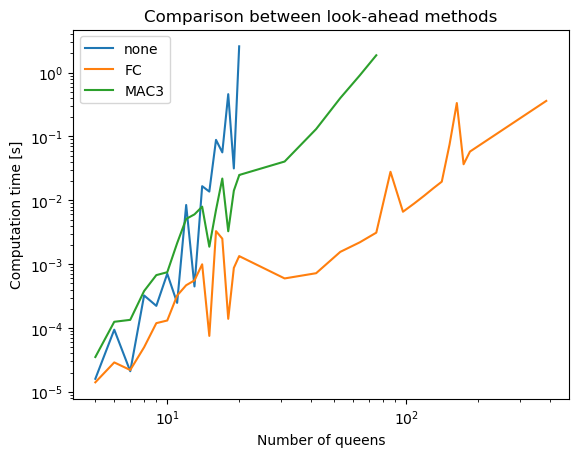

In [29]:
close()
yscale("log")
xscale("log")
for look_ahead_method in ["none", "FC", "MAC3"]
    plot(sizes[look_ahead_method], times[look_ahead_method], label=look_ahead_method)
end
legend()
xlabel("Number of queens")
ylabel("Computation time [s]")
title("Comparison between look-ahead methods")
show()

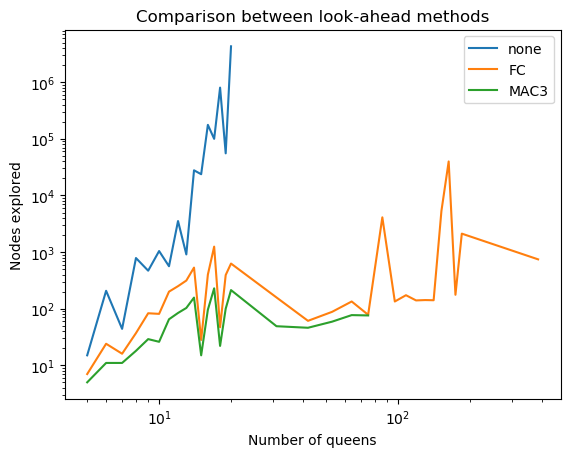

In [30]:
close()
yscale("log")
xscale("log")
for look_ahead_method in ["none", "FC", "MAC3"]
    plot(sizes[look_ahead_method], nodes[look_ahead_method], label=look_ahead_method)
end
legend()
xlabel("Number of queens")
ylabel("Nodes explored")
title("Comparison between look-ahead methods")
show()

Variable selection

In [31]:
sizes = Dict{String, Array{Int64, 1}}()
times = Dict{String, Array{Float64, 1}}()

for var_selection_method in ["order", "random", "domain_size", "domain_size_better", "domain_size_random"]
    sizes[var_selection_method] = Int64[]
    times[var_selection_method] = Float64[]
end

@showprogress for N in vcat(collect(5:20), collect(20:11:200), collect(200:31:400))
    for var_selection_method in ["order", "random", "domain_size", "domain_size_better", "domain_size_random"]
        nqueens = define_nqueens(N)
        set_params(nqueens, Dict("variable_selection"=>var_selection_method))
        res = solve!(nqueens)
        if res != nothing
            s, i, n, t = res
            push!(sizes[var_selection_method], N)
            push!(times[var_selection_method], t)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:04:33


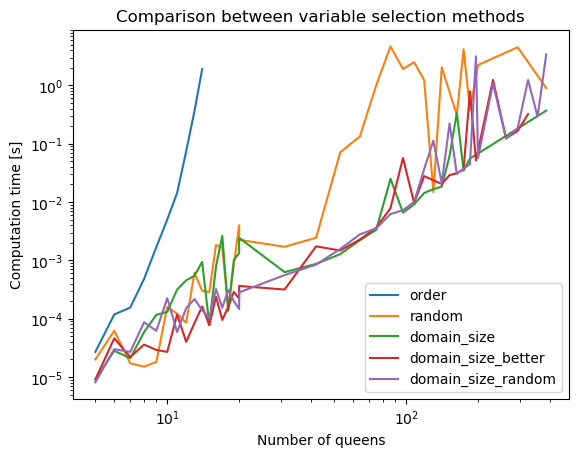

In [32]:
close()
yscale("log")
xscale("log")
for var_selection_method in ["order", "random", "domain_size", "domain_size_better", "domain_size_random"]
    plot(sizes[var_selection_method], times[var_selection_method],
        linestyle="-", label=var_selection_method)
end
legend()
xlabel("Number of queens")
ylabel("Computation time [s]")
title("Comparison between variable selection methods")
show()

### 3.2) Knight's tour

In [41]:
sizes = Dict{String, Array{Int64, 1}}()
times = Dict{String, Array{Float64, 1}}()

for piece in ["rook", "queen", "king", "knight"]
    sizes[piece] = Int64[]
    times[piece] = Float64[]
end

@showprogress for N in collect(3:10)
    for piece in ["rook", "queen", "king", "knight"]
        
        tour = define_tour(N, piece)
        set_params(tour, Dict("variable_selection"=>"domain_size_random"))
        res = solve!(tour, 100.)
        if res != nothing
            s, i, n, t = res
            push!(sizes[piece], N)
            push!(times[piece], t)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:12:01


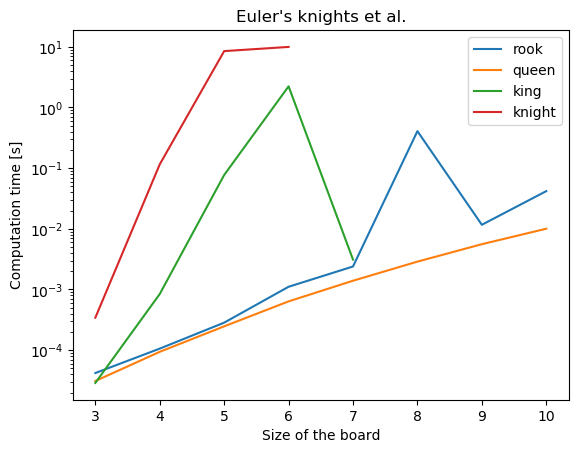

In [42]:
close()
yscale("log")
for piece in ["rook", "queen", "king", "knight"]
    plot(sizes[piece], times[piece],
        linestyle="-", label=piece)
end
legend()
xlabel("Size of the board")
ylabel("Computation time [s]")
title("Euler's knights et al.")
show()

### 3.3) Graph coloration

In [35]:
n_colors_dict = Dict{String, Int64}()
open("graphs/description.txt") do file
    for line in eachline(file)
        split_line = split(line, " ")
        file = split_line[1]
        n_colors_string = split(split_line[3], ",")[1]
        if n_colors_string != "?"
            n_colors = parse(Int64, n_colors_string)
            n_colors_dict[file] = n_colors
        end
    end
end

In [36]:
clique_search = DataFrame(
    file = String[],
    maxclique_length = Int64[],
    time = Float64[],
    maxclique = Array{Int64, 1}[]
)

coloring_results = DataFrame(
    file = String[],
    n_colors = Int64[],
    solved = Bool[],
    coloring_exists = Bool[],
    time = Float64[],
    nodes = Int64[],
    instantiation = Array{Int64, 1}[],
)

tricky_files = [
    "school_nsh.col",
    "school.col",
    "zeroin.i.1.col",
    "zeroin.i.2.col",
    "zeroin.i.3.col",
    "queen9_9.col"
]

max_colors = 15
max_time = 30.

for file in readdir("graphs")
    l = length(file)
    if (file[l-3:l] == ".col") & !(file in tricky_files)
        n_vertices, edges = read_graph("graphs/" * file)
        maxclique, t = find_maxclique(n_vertices, edges)
        maxclique_length = length(maxclique)
        push!(clique_search, (file, maxclique_length, t, maxclique))
        CSV.write("graphs/clique_search.csv", clique_search)
        
        for n_colors in 1:max_colors
            coloring = define_coloring(n_vertices, edges, n_colors, maxclique)
            println(file, " - ", n_colors, " colors")
            set_params(coloring, Dict("variable_selection"=> "domain_size_random"))
            res = solve!(coloring, max_time)
            if res != nothing
                (s, i, n, t) = res
                push!(coloring_results,
                    (file, n_colors, true, s, t, n, i)
                )
                println("Coloring exists: ", s)
                println("Solving time: ", t)
                if s
                    break
                end
            else
                push!(coloring_results,
                    (file, n_colors, false, false, max_time, -1, [])
                )
                println("Time out")
                break
            end
            println()
        end
        CSV.write("graphs/coloring_results.csv", coloring_results)
    end
end

anna.col - 1 colors
Coloring exists: false
Solving time: 6.794929504394531e-5

anna.col - 2 colors
Coloring exists: false
Solving time: 0.00010514259338378906

anna.col - 3 colors
Coloring exists: false
Solving time: 0.00013709068298339844

anna.col - 4 colors
Coloring exists: false
Solving time: 0.0003581047058105469

anna.col - 5 colors
Coloring exists: false
Solving time: 0.0002288818359375

anna.col - 6 colors
Coloring exists: false
Solving time: 0.0003600120544433594

anna.col - 7 colors
Coloring exists: false
Solving time: 0.0003719329833984375

anna.col - 8 colors
Coloring exists: false
Solving time: 0.0005221366882324219

anna.col - 9 colors
Coloring exists: false
Solving time: 0.0005469322204589844

anna.col - 10 colors
Coloring exists: false
Solving time: 0.00047588348388671875

anna.col - 11 colors
Coloring exists: true
Solving time: 0.0033299922943115234
david.col - 1 colors
Coloring exists: false
Solving time: 4.7206878662109375e-5

david.col - 2 colors
Coloring exists: fa

inithx.i.1.col - 1 colors
Coloring exists: false
Solving time: 0.0007669925689697266

inithx.i.1.col - 2 colors
Coloring exists: false
Solving time: 0.0006771087646484375

inithx.i.1.col - 3 colors
Coloring exists: false
Solving time: 0.0009069442749023438

inithx.i.1.col - 4 colors
Coloring exists: false
Solving time: 0.0011370182037353516

inithx.i.1.col - 5 colors
Coloring exists: false
Solving time: 0.0012781620025634766

inithx.i.1.col - 6 colors
Coloring exists: false
Solving time: 0.0015180110931396484

inithx.i.1.col - 7 colors
Coloring exists: false
Solving time: 0.001995086669921875

inithx.i.1.col - 8 colors
Coloring exists: false
Solving time: 0.0020520687103271484

inithx.i.1.col - 9 colors
Coloring exists: false
Solving time: 0.002279996871948242

inithx.i.1.col - 10 colors
Coloring exists: false
Solving time: 0.0026581287384033203

inithx.i.1.col - 11 colors
Coloring exists: false
Solving time: 0.0029571056365966797

inithx.i.1.col - 12 colors
Coloring exists: false
Solv

Time out
le450_15d.col - 1 colors
Coloring exists: false
Solving time: 0.0002391338348388672

le450_15d.col - 2 colors
Coloring exists: false
Solving time: 0.00030612945556640625

le450_15d.col - 3 colors
Coloring exists: false
Solving time: 0.0004150867462158203

le450_15d.col - 4 colors
Coloring exists: false
Solving time: 0.0005300045013427734

le450_15d.col - 5 colors
Coloring exists: false
Solving time: 0.0006279945373535156

le450_15d.col - 6 colors
Coloring exists: false
Solving time: 0.000782012939453125

le450_15d.col - 7 colors
Coloring exists: false
Solving time: 0.0009150505065917969

le450_15d.col - 8 colors
Coloring exists: false
Solving time: 0.0010390281677246094

le450_15d.col - 9 colors
Coloring exists: false
Solving time: 0.0011169910430908203

le450_15d.col - 10 colors
Coloring exists: false
Solving time: 0.0013020038604736328

le450_15d.col - 11 colors
Coloring exists: false
Solving time: 0.00139617919921875

le450_15d.col - 12 colors
Coloring exists: false
Solving

miles1500.col - 1 colors
Coloring exists: false
Solving time: 0.00013399124145507812

miles1500.col - 2 colors
Coloring exists: false
Solving time: 0.00016188621520996094

miles1500.col - 3 colors
Coloring exists: false
Solving time: 0.0001678466796875

miles1500.col - 4 colors
Coloring exists: false
Solving time: 0.00023102760314941406

miles1500.col - 5 colors
Coloring exists: false
Solving time: 0.00028896331787109375

miles1500.col - 6 colors
Coloring exists: false
Solving time: 0.00032591819763183594

miles1500.col - 7 colors
Coloring exists: false
Solving time: 0.0006349086761474609

miles1500.col - 8 colors
Coloring exists: false
Solving time: 0.0008060932159423828

miles1500.col - 9 colors
Coloring exists: false
Solving time: 0.0005400180816650391

miles1500.col - 10 colors
Coloring exists: false
Solving time: 0.0005869865417480469

miles1500.col - 11 colors
Coloring exists: false
Solving time: 0.0006759166717529297

miles1500.col - 12 colors
Coloring exists: false
Solving time

mulsol.i.4.col - 1 colors
Coloring exists: false
Solving time: 9.703636169433594e-5

mulsol.i.4.col - 2 colors
Coloring exists: false
Solving time: 0.00013709068298339844

mulsol.i.4.col - 3 colors
Coloring exists: false
Solving time: 0.00018906593322753906

mulsol.i.4.col - 4 colors
Coloring exists: false
Solving time: 0.00024390220642089844

mulsol.i.4.col - 5 colors
Coloring exists: false
Solving time: 0.0002951622009277344

mulsol.i.4.col - 6 colors
Coloring exists: false
Solving time: 0.0003509521484375

mulsol.i.4.col - 7 colors
Coloring exists: false
Solving time: 0.0005028247833251953

mulsol.i.4.col - 8 colors
Coloring exists: false
Solving time: 0.00046706199645996094

mulsol.i.4.col - 9 colors
Coloring exists: false
Solving time: 0.0005159378051757812

mulsol.i.4.col - 10 colors
Coloring exists: false
Solving time: 0.0005860328674316406

mulsol.i.4.col - 11 colors
Coloring exists: false
Solving time: 0.0006451606750488281

mulsol.i.4.col - 12 colors
Coloring exists: false
So

Time out
queen14_14.col - 1 colors
Coloring exists: false
Solving time: 0.0001761913299560547

queen14_14.col - 2 colors
Coloring exists: false
Solving time: 0.00015306472778320312

queen14_14.col - 3 colors
Coloring exists: false
Solving time: 0.00020503997802734375

queen14_14.col - 4 colors
Coloring exists: false
Solving time: 0.0002589225769042969

queen14_14.col - 5 colors
Coloring exists: false
Solving time: 0.0004680156707763672

queen14_14.col - 6 colors
Coloring exists: false
Solving time: 0.00046515464782714844

queen14_14.col - 7 colors
Coloring exists: false
Solving time: 0.0006041526794433594

queen14_14.col - 8 colors
Coloring exists: false
Solving time: 0.0007429122924804688

queen14_14.col - 9 colors
Coloring exists: false
Solving time: 0.0007541179656982422

queen14_14.col - 10 colors
Coloring exists: false
Solving time: 0.0008459091186523438

queen14_14.col - 11 colors
Coloring exists: false
Solving time: 0.0007021427154541016

queen14_14.col - 12 colors
Coloring exis

InterruptException: InterruptException: